**Symbolic Regression**

____________

In [129]:
import numpy as np
import random
import heapq as h
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [656]:
class Node:
    # initalize Function_node with name, children
    def __init__(self, function_name, value=None):
        self.num_childs = 0
        self.function_name = function_name
        if self.function_name == 'const':
            if value == None:
                self.value = 0
            else:
                self.value = value
        if self.function_name in ['*', '+', '-']:
            self.req_num_childs = 2
        else:
            self.req_num_childs = 0
    
    def add_child(self):
        self.num_childs += 1
    
    def can_add_child(self):
        if self.num_childs < self.req_num_childs:
            return True
        else:
            return False

    def __str__(self):
        if  self.function_name in ['const']:
            return f"{self.value}"
        else:
            return f"{self.function_name}"

In [786]:
class Heap(Node):
    
    def __init__(self, length = 1):
        self.heap   = np.full(length, None, dtype=object)
        self.operator = ['*', '+', '-']
        self.non_operator = ['x', 'const']
    
    
    
    def get_parent_idx(self, child_idx):
        return (child_idx-1) // 2

    def get_parent(self, child_idx):
        parent_idx = self.get_parent_idx(child_idx)
        return self.heap[parent_idx] 
    
    def get_left_child_idx(self, parent_idx):
        return 2 * parent_idx + 1

    def get_right_child_idx(self, parent_idx):
        return 2 * parent_idx + 2

    def get_left_child(self, parent_idx):
        left_child = self.heap[self.get_left_child_idx(parent_idx)]
        return left_child

    def get_right_child(self, parent_idx):
        right_child = self.heap[self.get_right_child_idx(parent_idx)]
        return right_child

    def get_children_idx(self, parent_idx):
        return 2 * parent_idx + 1, 2 * parent_idx + 2
    
    def get_children(self, parent_idx):
        child_1_idx, child_2_idx = self.get_children_idx(parent_idx)
        return self.heap[child_1_idx], self.heap[child_2_idx]
    
    def get_children_type(self, parent_idx):
        L, R = self.get_children(parent_idx)
        return type(L), type(R)
    
    
    
    
    # EVALUATE A NODE
    def evaluate(self, node_ind = 0, X = None): # tree root = 0
        
        # Evaluates a node given its index
        def node_operation(operator, operand):
            if   operator == '*':   return  operand[0] * operand[1]
            elif operator == '+':   return  operand[0] + operand[1]
            elif operator == '-':   return  operand[0] - operand[1]
        
        # MAIN LOOP
        L_child, R_child = self.get_children(node_ind)
        L_indx, R_indx   = self.get_children_idx(node_ind)
        children_types   = self.get_children_type(node_ind)
        
        
        #TODO: deal with NAN child if non trig or dual nan for operator leaf

        #CHECKS left child
        # If an operator, evaluate recursively returning a constant
        # If X, assign it
        if type(L_child) is None: # how to check for nan... dont ask why just go with it 
                #print("fuck yes")
                pass   
        elif L_child.function_name in self.operator:
            L_child.value = self.evaluate(node_ind = 2*node_ind + 1, X = X)
            #L_child.function_name = 'const'
            
        elif L_child.function_name == 'x':
            L_child.value = X
            #L_child.function_name = 'const'
        
        
        #TODO why the fuck is checking for nan = false same for right child: datatype issue, lesson: use None next time. 
        if type(R_child) is None: # dont ask why just go with it 
                #print("fuck yes")
                pass                       
        elif R_child.function_name in self.operator: 
            R_child.value = self.evaluate(node_ind = 2*node_ind + 2, X = X)
            #R_child.function_name = 'const' 
        elif R_child.function_name == 'x':
            R_child.value = X
            #R_child.function_name = 'const'
        
        
        # terminating state: both children are constandts (floats) or Nan (with at least a constant) after being evaluated
        node_operator = self.heap[node_ind].function_name
        try: 
            if Node not in children_types: 
                raise TypeError(f"Invalid children type for operator: {node_operator} \n\t L/R children are: {(L_child, R_child)}")
               
            #elif node_operator in self.trig_operators: # i.e its sin, cos, tan etc (as defined above
                
            #    if float not in children_types:
            #        raise ValueError(f"Invalid children type for operator: {node_operator} \n\t L/R children are: {(L_child, R_child)}")
            #    elif not type(L_child) == float: 
            #        node_val = node_operation(node_operator,L_child.value)
            #    elif R_child:
            #        node_val = node_operation(node_operator,R_child.value)
            
            else:
                node_val = node_operation(node_operator,(L_child.value, R_child.value))
                
        except ValueError as err_msg: 
            sys.exit()
        
        
        
        #DIAGNOSTIC
        msg_out = (
            f"at the root evaluating with:\n\t - parent node index {node_ind}"
                f"\n\t - operator {node_operator}"
                f"\n\t - with children {[str(x) for x in self.heap[[L_indx, R_indx]]]}"
            f"\n result passed {node_val}"
                )
        #print(msg_out)
        return node_val
    
    
    #TODO: Test the below (not run)
    def MSE(self, point_cloud, plotting = False): 
        #RECALL: MSE = (1/n) * Σ(actual – forecast) ^2
        X_arr  = point_cloud[:,0]
        y      = point_cloud[:,1]
        y_pred = np.array([self.evaluate(X = x) for x in X_arr])
        MSE = np.mean((y_pred - y) ** 2)
        #np.sum(np.square(y_pred-y)/y.shape[0])
        
        if plotting: 
            self.plot_approximation(X_arr,y_pred, y_true = y)
            
        return MSE
    
    
    
    
    def get_depth(self):
        return int(math.floor(math.log2(len(self.heap) + 1)))-1
    
    def has_root(self):
        if self.heap[0] == None:
            return False
        else:
            return True
    
    def add_root(self, new_node):
        self.heap[0] = new_node
    
    def add_child(self, parent_idx, new_node):
        #print("trying to add child for {}".format(parent_idx))
        # Check if parent can add child
        # True if can_add_child
        if self.heap[parent_idx].can_add_child():
            # Keep track of added child in node
            self.heap[parent_idx].add_child_count()
            # Get child number [either 1 or 2 since we're adding above]
            child_num = self.heap[parent_idx].num_childs
            # Check if we can add child
            if 2*parent_idx+child_num < len(self.heap):
                self.heap[2*parent_idx+child_num] = new_node
            # Resize if needed
            else:
                prev_n = len(self.heap)
                prev_heap = self.heap
                # Create new heap that is 'full' to depth where new child will be
                self.heap = np.full(2**(math.floor(math.log2(2*parent_idx+child_num + 1))+1)-1, None, dtype=object)
                self.heap[:prev_n] = prev_heap
                self.heap[2*parent_idx+child_num] = new_node
        # Can't add child
        else:
            # What to do here?
            #print("can't add child")
            pass
        
        
    def randomize_heap(self, parent_idx=0):
        # Check if heap has root
        if self.has_root() == False:
            # Add operator rood node if not
            # ******* WILL MAYBE WANT TO CHANGE ********
            self.add_root(Node(random.choice(self.operator)))
        
        #print("...")
        #print("Depth:{}\nTree: \n{}".format(self.get_depth(), self.__str__()))
        
        
        # Kepp adding subtrees up to depth = 1
        if self.get_depth() < 1:
            # Add random nodes until sub tree is full
            while self.heap[parent_idx].can_add_child():
                typ = random.choice(self.non_operator) if random.randint(0,1) < 1 else random.choice(self.operator)
                self.add_child(parent_idx, Node(typ, value = random.uniform(0,5) if typ == 'const' else None))
        
        
            # Recursively add random subtrees for all children
            # If subtree is a non_operator it will not loop as num_childs = 0
            for i in range(self.heap[parent_idx].num_childs):
                self.randomize_heap(2*parent_idx + (i+1))
        
        # Make sure all operators required number of operands
        # Thus max depth of tree = 2
        else:
            # Add random operands for all children that require them
            while self.heap[parent_idx].can_add_child():
                typ = random.choice(self.non_operator)
                self.add_child(parent_idx, Node(typ, value = random.uniform(0,5) if typ == 'const' else None))
            #for i in range(self.heap[parent_idx].num_childs):
            #    typ = random.choice(self.non_operator)
            #    self.add_child(2*parent_idx + (i+1), Node(typ, value=random.uniform(0,5) if typ == 'const' else None))  
    
    
    # GPT-4
    def print_heap_tree(self, index=0, prefix="", is_left=True):
        output = ""
        if index < len(self.heap) and self.heap[index] is not None:
            # Process right child first (going down)
            output += self.print_heap_tree(index=2*index+2, prefix=prefix + ("|   " if is_left else "    "), is_left=False)
            # Add the current node to the output
            output += prefix + "|-- " + str(self.heap[index]) + "\n"
            # Process left child
            output += self.print_heap_tree(index=2*index+1, prefix=prefix + ("|   " if not is_left else "    "), is_left=True)
        # else:
            # Indicate the absence of a node with [...]
            # output += prefix + "|-- [...]\n"
        return output

    def __str__(self):
        return self.print_heap_tree()


In [796]:
rand_h = Heap()
rand_h.randomize_heap()

print("-------------")

print(rand_h.get_depth())
print(rand_h)

-------------
2
|       |-- 4.591484896988459
|   |-- +
|   |   |-- 4.311999606219064
|-- -
    |-- x



In [801]:
rand_h.get_children(0)

(<__main__.Node at 0x7fcf493c4ee0>, <__main__.Node at 0x7fcf493c43d0>)

In [787]:
# OPEN DATA FILE FOR X VALUES
x_list = []
with open('Bronze.txt', 'r') as file:
    for line in file:
        x, y = map(float, line.strip().strip('()').split(','))
        x_list.append(x)
x_arr = np.array(x_list)
        
# GENERATE DATA FOR RANDOM AFFINE FUNCTION (y = 0.5x - 3)
y_list = []

m = 0.5 #random.uniform(0,3)
b = 3 #random.uniform(0,3)
sign = -1 #random.choice([1, -1])
y = lambda x: m*x + sign*b
for i in range(len(x_arr)):
    y_list.append(y(x_arr[i]))
y_arr = np.array(y_list)

In [793]:
# for 100 generations
# for a population of 10 random heaps
# evaluate heap
# keep track of best performing one

evaluations = 100
population = 10

best_heaps_list = np.full(evaluations, None, dtype=object)
best_mse = []

for i in range(evaluations):
    current_best_heap = None
    current_best_mse = np.inf
    for j in range(population):
        h = Heap()
        h.randomize_heap()
        mse = h.MSE(point_cloud=np.array([x_arr, y_arr]).T)
        if mse < current_best_mse:
            current_best_mse = mse
            current_best_heap = h
    best_heaps_list[i] = current_best_heap
    best_mse.append(current_best_mse)

print(best_heaps_list[np.argmin(best_mse)])

|   |-- 3.510642671544808
|-- -
    |   |-- 0.7506122776473545
    |-- *
        |-- x



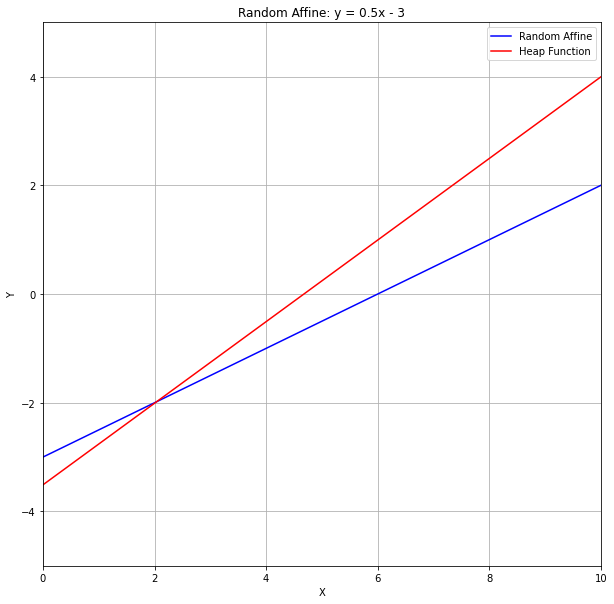

MSE: 1.075620992367308


In [794]:
# GENERATE DATA FOR OUR RANDOM HEAP
y_list = []
for i in range(len(x_arr)):
    y_list.append(best_heaps_list[np.argmin(best_mse)].evaluate(X=x_arr[i]))
y_heap = np.array(y_list)


# Plotting the line graph
plt.figure(figsize=(10, 10))
plt.xlim(0, 10)
plt.ylim(-5, 5)
plt.plot(x_arr, y_rand, '-', label='Random Affine', color='blue')
plt.plot(x_arr, y_heap, '-', label='Heap Function', color='red')
plt.title('Random Affine: y = {:.2g}x {} {:.2g}'.format(m, '+' if sign > 0 else '-', b))
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: {}'.format(best_mse[np.argmin(best_mse)]))

In [759]:
rand_h = Heap()
rand_h.randomize_heap()

print("-------------")

print(rand_h.get_depth())
print(rand_h)

...
Depth:0
Tree: 
|-- +

...
Depth:1
Tree: 
|   |-- x
|-- +
    |-- x

...
Depth:1
Tree: 
|   |-- x
|-- +
    |-- x

-------------
1
|   |-- x
|-- +
    |-- x



In [664]:
rand_h.evaluate(0, 5)

115.58473960513469

In [211]:
# Node can be one of the following:
# ['*', '+', '-', 'x', 'const']

# '*' has 2 children
# '+' has 2 children
# '-' has 2 children
# 'x' has 0 children
# 'const' has a value & 0 children

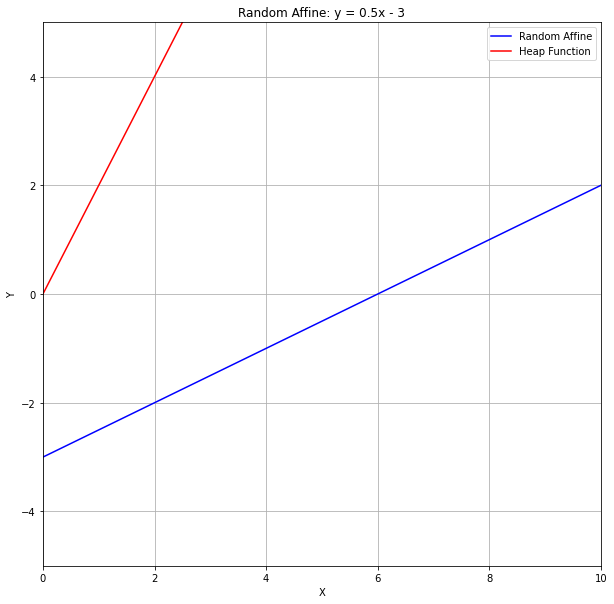

MSE: 129.0375376876879, 129.03753768768786


In [760]:
# OPEN DATA FILE FOR X VALUES
x_list = []
with open('Bronze.txt', 'r') as file:
    for line in file:
        x, y = map(float, line.strip().strip('()').split(','))
        x_list.append(x)
x_arr = np.array(x_list)
        
# GENERATE DATA FOR RANDOM AFFINE FUNCTION (y = 0.5x - 3)
y_list = []

m = 0.5 #random.uniform(0,3)
b = 3 #random.uniform(0,3)
sign = -1 #random.choice([1, -1])
y = lambda x: m*x + sign*b
for i in range(len(x_arr)):
    y_list.append(y(x_arr[i]))
y_rand = np.array(y_list)


# GENERATE DATA FOR OUR RANDOM HEAP
y_list = []
for i in range(len(x_arr)):
    y_list.append(rand_h.evaluate(X=x_arr[i]))
y_heap = np.array(y_list)


# Plotting the line graph
plt.figure(figsize=(10, 10))
plt.xlim(0, 10)
plt.ylim(-5, 5)
plt.plot(x_arr, y_rand, '-', label='Random Affine', color='blue')
plt.plot(x_arr, y_heap, '-', label='Heap Function', color='red')
plt.title('Random Affine: y = {:.2g}x {} {:.2g}'.format(m, '+' if sign > 0 else '-', b))
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

mse1 = np.sum(np.square(y_heap-y_rand)/y_rand.shape[0])
mse2 = np.mean((y_heap - y_rand) ** 2)

print('MSE: {}, {}'.format(mse1, mse2))

In [78]:
# LOAD HW2 BRONZE DATA
# Initialize lists to store x and y values
x_list = []
y_list = []

# Open and read the text file
with open('Bronze.txt', 'r') as file:
    for line in file:
        # Strip whitespace and split the values using comma as delimiter
        x, y = map(float, line.strip().strip('()').split(','))
        x_list.append(x)
        y_list.append(y)

# Convert lists to numpy arrays
x_vals = np.array(x_list)
y_vals = np.array(y_list)

In [47]:
# GENERATE DATA FOR SYMBOLIC REGRESSION
y = lambda x: (x-3.5)**2 -15

y_vals_test = []

for i in range(len(x_vals)):
    y_vals_test.append(y(x_vals[i]))

In [ ]:
    
    def randomize_root_heap(self):
        self.add_root(Node(random.choice(self.operator)))
        typ = random.choice(self.non_operator)
        self.add_child(0, Node(typ, value=random.uniform(0,5) if typ == 'const' else None))
        typ = random.choice(self.non_operator)
        self.add_child(0, Node(typ, value=random.uniform(0,5) if typ == 'const' else None))

In [22]:
def resize_binary_tree(tree, new_size):
    """Resize a binary tree represented as a numpy array without repeating values."""
    padding_size = new_size - tree.size
    if padding_size < 0:
        raise ValueError("New size should be greater than the current size.")
    return np.pad(tree, (0, padding_size), mode='constant', constant_values=None)

# Example:
tree = np.array([1, 2, 3, None, None, None, None])  # a binary tree with root and two child nodes
print(tree)  # Before resize

# Say we want to add another level. This means we need a total of 2^3 - 1 = 15 nodes.
tree = resize_binary_tree(tree, 15)  
print(tree)  # After resize

[1 2 3 None None None None]
[1 2 3 None None None None None None None None None None None None]
